In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
from scipy.io import loadmat
from datetime import datetime, timedelta
sys.path.append('/home/manu/TFG_repo/scripts')

In [103]:
from analysis_routines import *
from config import data_dir, reports_dir
from plotting_routines_xr import *
from processing_routines import datenum_to_epoch
from wavelet_analysis import wavelet_power_spectrum
from harmonic_analysis import *
from scipy.stats import chi2
from statsmodels.tsa.stattools import acf, adfuller, ccf, ccovf
plt.style.use('/home/manu/TFG_repo/notebooks/report.mplstyle')

In [121]:
# load data and fit
fit_chain = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_fci.csv')
chain = load_time_series_xr('processed/AGL_20181116_chain_xrcompatible.nc')
station7 = load_time_series_xr('station7_complete.nc')
G05 = pd.read_csv(data_dir / 'SHDR_fit/aux/G05.csv', index_col='date', parse_dates=True)
delta05 = pd.read_csv(data_dir / 'SHDR_fit/aux/delta05_ci.csv', index_col='date', parse_dates=True)
D1_ = fit_chain.D1

In [8]:
# global variables
figures_dir = reports_dir / 'figures'
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [34]:
def get_figsize(wf=0.5, hf=None, columnwidth=455.24411):
    """Parameters:
      - wf (float):  width fraction in columnwidth units
      - hf (float):  height fraction in columnwidth units.
                   Set by default to golden ratio.
      - columnwidth (float): width of the column in latex. Get this from LaTeX 
                               using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    
    if hf is None:
        hf = 1/1.333333
    
    fig_width_pt = columnwidth*wf 
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]

# Capitulo 1: Conceptos básicos de onceanografía física

[4.409448969143489, 3.307087553629505]


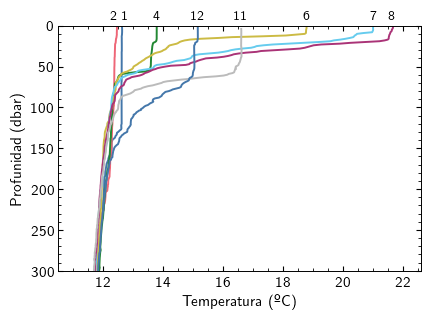

In [85]:
# profiles_2014
figsize = get_figsize(0.7)
fig, ax = plt.subplots(figsize=figsize)
year = station7.temp.sel(date='2014')
months_int = [0, 1, 3, 5, 6, 7, 10, 11]
for i in months_int:
    #k = i*2 + 1
    ax.plot(year[i], station7.pres)
    if i==0:
        ax.text(year[i][np.isfinite(year[i])][3] +0.1, -8, i + 1, ha='center')
    elif i==1:
        ax.text(year[i][np.isfinite(year[i])][3] -0.1, -8, i + 1, ha='center')     
    else:
        ax.text(year[i][np.isfinite(year[i])][3], -8, i + 1, ha='center')
ax.set_ylim(300, 0)
ax.set_xlim(10.5, None)
ax.set_xlabel('Temperatura (ºC)')
ax.set_ylabel('Profunidad (dbar)')
fig.tight_layout()
fig.savefig(reports_dir / 'figures/profiles_2014.pdf', dpi=300)
plt.show()

# Capitulo 5: Ondas internas

## Espectros termistores y parámetros

In [40]:
# espectros termistores welch

temp_28 = chain.temp.loc[:, 28].data
freqs_28, psd_28, dof_28 = windowed_spectrum(temp_28, 5/60/60/24, 28, 3) #window 42.67

temp_53 = chain.temp.loc[:, 53].data
freqs_53, psd_53, dof_53 = windowed_spectrum(temp_53, 5/60/60/24, 28, 3) #window 42.67

temp_63 = chain.temp.loc[:, 63].data
freqs_63, psd_63, dof_63 = windowed_spectrum(temp_63, 5/60/60/24, 28, 3) #window 42.673

temp_96 = chain.temp.loc[:, 96].data
freqs_96, psd_96, dof_96 = windowed_spectrum(temp_96, 5/60/60/24, 28, 3) #window 42.67

temp_126 = chain.temp.loc[:, 126].data
freqs_126, psd_126, dof_126 = windowed_spectrum(temp_126, 5/60/60/24, 28, 3) #window 42.67

temp_176 = chain.temp.loc[:, 176].data
freqs_176, psd_176, dof_176 = windowed_spectrum(temp_176, 5/60/60/24, 28, 3) #window 42.67

In [42]:
# espectros parámetros ajuste
D1_ = fit_chain['D1']
freqs_D1, psd_D1, dof_D1 = windowed_spectrum(D1_, 5/60/60/24, 28, 3) #window 42.67

a2_ = fit_chain['a2']
freqs_a2, psd_a2, dof_a2 = windowed_spectrum(a2_, 5/60/60/24, 28, 3) #window 42.67

a1_ = fit_chain['a1']
freqs_a1, psd_a1, dof_a1 = windowed_spectrum(a1_, 5/60/60/24, 28, 3) #window 42.67

freqs_G05, psd_G05, dof_G05 = windowed_spectrum(G05.x, 5/60/60/24, 28, 3) #window 42.67


In [38]:
coriolis_frequency = 2*7.2921e-5*np.sin(np.deg2rad(chain.lat.data)[0])
coriolis_freq_cps = coriolis_frequency/2/np.pi
coriolis_freq_cpd = coriolis_freq_cps*60*60*24
M2_cpd = 1/12.42061*24
M4_cpd = 1/6.210301*24
K1_cpd = 1/23.934470*24
Q1_cpd = 1/28.006223*24
M3_cpd = 1/8.280401*24
M8_cpd = 1/3.105150*24
O1_cpd = 1/1/25.819351*24 # not present in temperature record
Q1_2_cpd = 1/28.006223*24
M6_cpd = 1/4.14020*24

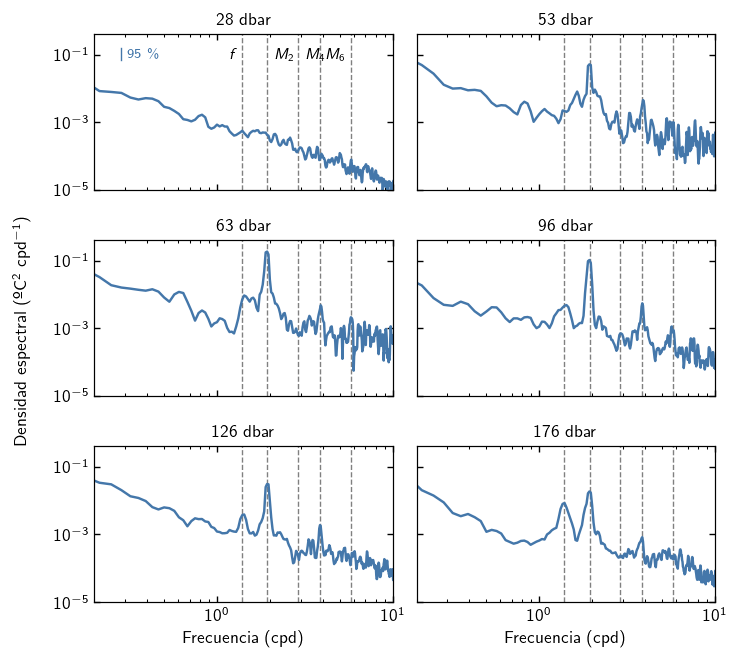

In [44]:
vlines = [coriolis_freq_cpd, M2_cpd, M3_cpd, M4_cpd, M6_cpd]
texts = ['f', 'M2', 'M4', ]

figsize=(get_figsize(0.95, 0.9))
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=figsize)

#limits
ylim = (10**-5, 4*10**-1)

axs[0,0].set_xlim(2*10**-1, 10**1)
axs[0,0].set_ylim(ylim)
for ax in axs.reshape(6):
    ax.vlines(vlines, *ylim, ls='--', color='grey', lw=0.8)
axs[0,0].text(vlines[0] - 0.2, 10**-1, '$f$', ha='left', fontsize=9, va='center')
axs[0,0].text(vlines[1] + 0.2, 10**-1, '$M_2$', ha='left', fontsize=9, va='center')
axs[0,0].text(vlines[2] + 0.3, 10**-1, '$M_4$', ha='left', fontsize=9, va='center')
axs[0,0].text(vlines[3] + 0.3, 10**-1, '$M_6$', ha='left', fontsize=9, va='center')


axs[0,0].loglog(freqs_28, psd_28)
axs[0,0].set_title('28 dbar')

axs[0,1].loglog(freqs_53, psd_53)
axs[0,1].set_title('53 dbar')


axs[1,0].loglog(freqs_63, psd_63)
axs[1,0].set_title('63 dbar')


axs[1,1].loglog(freqs_96, psd_96)
axs[1,1].set_title('96 dbar')


axs[2,0].loglog(freqs_126, psd_126)
axs[2,0].set_title('126 dbar')
axs[2,0].set_xlabel('Frecuencia (cpd)')


axs[2,1].loglog(freqs_176, psd_176)
axs[2,1].set_title('176 dbar')
axs[2,1].set_xlabel('Frecuencia (cpd)')


chi_2 = dof_28 / chi2.ppf([0.025, 0.975], dof_28)
y_bar = 10**-1
conf = y_bar * chi_2
axs[0,0].plot([0.09, 0.09], conf, transform=axs[0,0].get_yaxis_transform(), c=colors[0], lw=0.8)
axs[0,0].text(0.11, y_bar, '95 $\%$', transform=axs[0,0].get_yaxis_transform(), fontsize=8, va='center',
             color=colors[0])

fig.supylabel('Densidad espectral (ºC$^2$ cpd$^{-1}$)', fontsize=10)

fig.tight_layout()
fig.subplots_adjust(wspace=0.08)
#fig.savefig(figures_dir / 'welch_column.pdf', dpi=300)

plt.gcf().set_dpi(125)
plt.show()

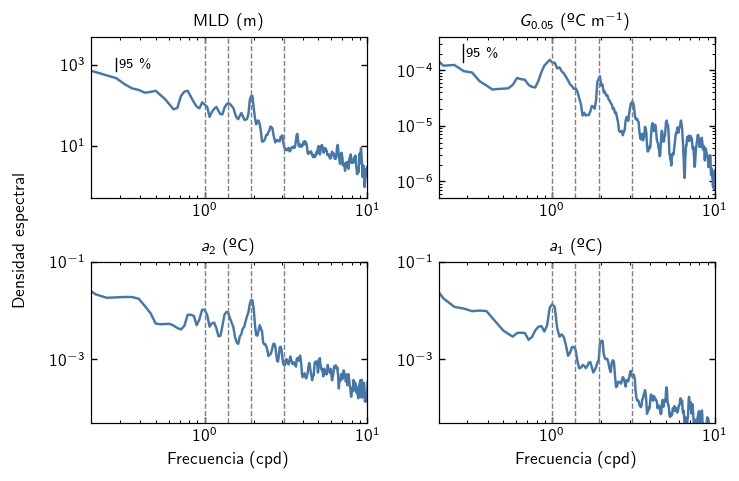

In [407]:
figsize = (get_figsize(0.95, 0.66))
fig = plt.figure(figsize=figsize)
gs = plt.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.loglog(freqs_D1, psd_D1)
ax1.set_ylim(5*10**-1,None)
ax1.set_title('MLD (m)')

ax2 = fig.add_subplot(gs[0, 1])
ax2.loglog(freqs_G05, psd_G05)
ax2.set_ylim(5*10**-7, 4*10**-4)
ax2.set_title('$G_{0.05}$ (ºC m$^{-1}$)')

ax3 = fig.add_subplot(gs[1, 0])
ax3.loglog(freqs_a2, psd_a2)
ax3.set_ylim(5*10**-5, 10**-1)
ax3.set_title('$a_2$ (ºC)')
ax3.set_xlabel('Frecuencia (cpd)')

ax4 = fig.add_subplot(gs[1, 1])
ax4.loglog(freqs_a1, psd_a1)
ax4.set_ylim(5*10**-5, 10**-1)
ax4.set_xlabel('Frecuencia (cpd)')
ax4.set_title('$a_1$ (ºC)')

freq = 1/9*24
vlines = [1, coriolis_freq_cpd, M2_cpd, 1/7.8*24]

for ax in fig.get_axes():
    ax.set_xlim(2*10**-1, 10**1)
    ax.vlines(vlines, *ax.get_ylim(), ls='--', color='grey', lw=0.8)
    

chi_2 = dof_28 / chi2.ppf([0.025, 0.975], dof_28)
y_bar_ax1 = 10**3
ax1.plot([0.09, 0.09], chi_2*y_bar_ax1, transform=ax1.get_yaxis_transform(), c='k', lw=0.8)
ax1.text(0.10, y_bar_ax1, '95 $\%$', transform=ax1.get_yaxis_transform(), fontsize=8, va='center')


y_bar_ax2 = 2*10**-4
ax2.plot([0.09, 0.09], chi_2*y_bar_ax2, transform=ax2.get_yaxis_transform(), c='k', lw=0.8)
ax2.text(0.10, y_bar_ax2, '95 $\%$', transform=ax2.get_yaxis_transform(), fontsize=8, va='center')

fig.supylabel('Densidad espectral', fontsize=10)
fig.tight_layout()
#fig.subplots_adjust(, left=0.092)
fig.savefig(figures_dir / 'welch_parametres.pdf', dpi=300)

plt.gcf().set_dpi(125)
plt.show()

## Oscilaciones columna M2

### Noviembre

In [63]:
dn = 1 # get datapoints every 60 seconds, not every 5
date_1 = datetime(2018, 11, 24)

nov_fit = TidalComponentsFit.compute(fit_chain, period=[None, date_1, dn])

#nov_term = column_coefs([28, 33, 43, 48, 53, 63, 78, 96])
nov_term = column_coefs([28, 33, 43, 48, 53, 63, 78, 96, 108, 126, 151, 176])

nov_term.compute(chain, period=[None, date_1])

nov_G05 = coef_dataframe(G05.x, period=[None, date_1, dn])
nov_delta05ci = coef_dataframe(delta05.x, period=[None, date_1, dn])

#nov_term.clean() # todos los termistores tienen M2
nov_fit.clean()

In [12]:
def plot_column_oscilation(figsize, column_coefs, component, mld_coef, delta05_coef, 
                           pos1, pos2, x_arrow, arrow_width=0.000005, head_width=0.01, ylim=None, save=None):
    x = []
    ci = []
    depths = column_coefs.depths
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    
    mld_mean = mld_coef.attrs['mean']
    mld_ampl = mld_coef.loc[component]['A']
    delta_mean = delta05_coef.attrs['mean']

    delta_ampl = delta05_coef.loc[component]['A']
    
    for depth in depths:
        coef = getattr(column_coefs, 'd' + str(depth))
        value = coef.loc[component]['A']
        confidence = coef.loc[component]['A_ci']
        ci.append(confidence)
        x.append(value)
        
    fig, ax = plt.subplots(figsize=figsize)
    ax.errorbar(x, depths, xerr=ci, marker='o', linestyle='none', lw=0.8, capsize=3, c='k')
    ax.axhline(mld_mean, ls='--')
    ax.axhline(mld_mean + delta_mean, ls='--', c=colors[1])
    xlim = ax.get_xlim()
    
    if ylim is None:
        ax.set_ylim(max(depths) + 2, min(depths) - 2)
        
    else:
        ax.set_ylim(*ylim)
    mld_mean_arr = np.full(2, mld_mean)
    
    ax.fill_between((xlim[0], xlim[1]), (mld_mean_arr-mld_ampl), (mld_mean_arr+mld_ampl), color=colors[0], 
                     alpha=0.35)
    ax.fill_between((xlim[0], xlim[1]), (mld_mean + delta_mean-delta_ampl), (mld_mean + delta_mean+delta_ampl), 
                     color=colors[1], alpha=0.35)

    ax.set_xlim(*xlim)
    ax.set_xlabel('Amplitud de oscilación (ºC)')
    ax.set_ylabel('Profundidad (dbar)')
    #ax.set_title('Componente ' + component)
    
    norm_x = xlim[1] - xlim[0]
    norm_y = ax.get_ylim()[0] - ax.get_ylim()[1]

    
    ax.arrow(x = x_arrow, y = mld_mean - mld_ampl, dy=2*mld_ampl, dx=0, width=arrow_width*norm_x, 
             length_includes_head=True, head_width=head_width*norm_x, head_length=0.02*norm_y, color='k')
    ax.arrow(x = x_arrow, y = mld_mean + mld_ampl, dy=-2*mld_ampl, dx=0, width=arrow_width*norm_x, 
             length_includes_head=True, head_width=head_width*norm_x, head_length=0.02*norm_y, color='k')

    ax.arrow(x = x_arrow, y = mld_mean + delta_mean - delta_ampl, dy=2*delta_ampl, dx=0, width=arrow_width*norm_x,
             length_includes_head=True, head_width=head_width*norm_x, head_length=0.02*norm_y, color='k')
    ax.arrow(x = x_arrow, y = mld_mean + delta_mean + delta_ampl, dy=-2*delta_ampl, dx=0, width=arrow_width*norm_x,
             length_includes_head=True, head_width=head_width*norm_x, head_length=0.02*norm_y, color='k')
    ax.text(pos1[0], pos1[1], 'MLD', fontsize=9, va='center', ha='center')
    ax.text(pos2[0], pos2[1], r'$\Delta_{0.05}$', fontsize=9, va='center', ha='center')
    
    fig.tight_layout()
    
    if save is not None:
        fig.savefig(figures_dir / save, dpi=300)
    
    plt.show()

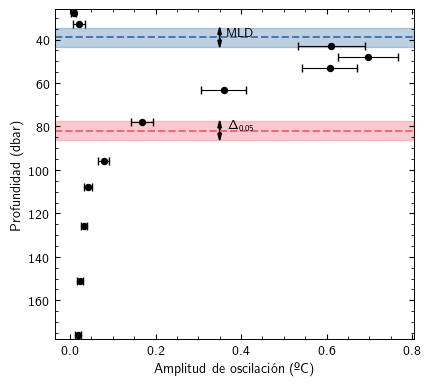

In [22]:
plot_column_oscilation(get_figsize(0.7, 0.9), nov_term, 'M2', nov_fit.D1, nov_delta05ci, pos1=[0.4, 36.8], 
                       pos2=[0.4, 79.785], x_arrow=0.35, save='colum_oscilation_M2_november.pdf')

### Enero

In [11]:
dn = 1 # get datapoints every 60 seconds, not every 5
date_2 = datetime(2019, 1, 5)
date_3 = datetime(2019, 1, 14) # o 14

jan_fit = TidalComponentsFit.compute(fit_chain, period=[date_2, date_3, dn])

#jan_term = column_coefs([78, 96, 108, 126, 151, 176])
jan_term = column_coefs([28, 33, 43, 48, 53, 63, 78, 96, 108, 126, 151, 176])

jan_term.compute(chain, period=[date_2, date_3, dn])

jan_G05 = coef_dataframe(G05.x, period=[date_2, date_3, dn])
jan_delta05ci = coef_dataframe(delta05.x, period=[date_2, date_3, dn])

#jan_term.clean()
jan_fit.clean()

In [233]:
jan_term.d28

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
K1,23.934470,62.600070,3.464887,0.016467,0.017339,135.977520,60.338969
M2,12.420601,18.182905,1.346772,0.008875,0.014989,151.265139,96.500176
M4,6.210301,4.527267,5.589864,0.004428,0.003671,208.927267,47.422465
M3,8.280401,3.941444,0.758035,0.004132,0.009302,264.351932,129.255660
M8,3.105150,2.874026,10.443677,0.003528,0.002140,158.977119,34.751585
2SK5,4.797373,2.395530,3.383846,0.003221,0.003432,311.401840,61.040941
2MK5,4.930880,2.393730,3.382462,0.003220,0.003432,110.519303,61.074358
M6,4.140200,2.298742,39.700654,0.003156,0.000982,82.307914,17.838660
3MK7,3.529641,0.786286,1.213680,0.001846,0.003283,217.329324,101.954713


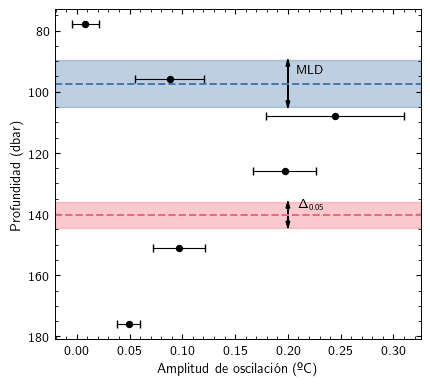

In [189]:
plot_column_oscilation(get_figsize(0.7, 0.9), jan_term, 'M2', jan_fit.D1, nov_delta05ci, pos1=[0.222, 93], 
                       pos2=[0.222, 137], x_arrow=0.20, ylim=[181, 73],
                       save='colum_oscilation_M2_jan.pdf')

### Principios noviembre

In [50]:
dn = 1 
date_4 = datetime(2018, 11, 30)
date_5 = datetime(2018, 12, 9)

dec_fit = TidalComponentsFit.compute(fit_chain, period=[date_4, date_5, dn])

#dec_term = column_coefs([28, 33, 43, 48, 53, 63, 78, 96, 108, 126])
depths_coefs = [28, 33, 43, 48, 53, 63, 78, 96, 108, 126, 151, 176]
dec_term = column_coefs(depths_coefs)

dec_term.compute(chain, period=[date_4, date_5, dn])

dec_G05 = coef_dataframe(G05.x, period=[date_4, date_5, dn])
dec_delta05ci = coef_dataframe(delta05.x, period=[date_4, date_5, dn])

#jan_term.clean()
dec_fit.clean()

In [152]:
dec_term.d126

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,92.139891,142.262004,0.051406,0.008448,33.463477,9.396022
M4,6.210301,1.735089,3.725050,0.007054,0.007164,149.239835,58.095818
K1,23.934470,1.733971,19.236596,0.007052,0.003151,223.333487,25.611128
M8,3.105150,1.508741,36.692132,0.006578,0.002128,254.788501,18.541030
M3,8.280401,0.789850,8.738016,0.004760,0.003156,51.482552,38.007142
3MK7,3.529641,0.763884,9.913935,0.004681,0.002914,125.610154,35.662729
2SK5,4.797373,0.528503,4.941129,0.003893,0.003433,70.037721,50.481218
M6,4.140200,0.419549,2.909746,0.003469,0.003986,208.512698,65.791966
2MK5,4.930880,0.380522,3.557907,0.003304,0.003433,183.258354,59.495107


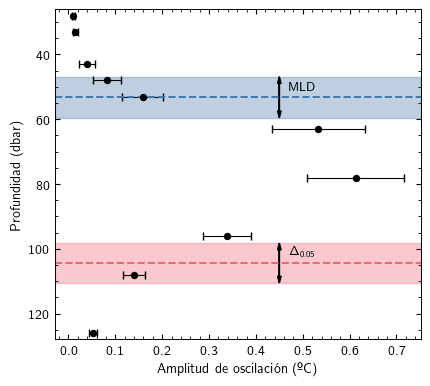

In [188]:
plot_column_oscilation(get_figsize(0.7, 0.9), dec_term, 'M2', dec_fit.D1, dec_delta05ci, pos1=[0.499, 50], 
                       pos2=[0.499, 101], x_arrow=0.45,
                       save='colum_oscilation_M2_dec.pdf')

In [19]:
def plot_column_oscilation_axes(ax, column_coefs, component, mld_coef, delta05_coef, 
                           pos1, pos2, x_arrow, arrow_width=0.000005, head_width=0.03, ylim=None, save=None):
    x = []
    ci = []
    depths = column_coefs.depths
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    
    mld_mean = mld_coef.attrs['mean']
    mld_ampl = mld_coef.loc[component]['A']
    delta_mean = delta05_coef.attrs['mean']

    delta_ampl = delta05_coef.loc[component]['A']
    
    for depth in depths:
        coef = getattr(column_coefs, 'd' + str(depth))
        value = coef.loc[component]['A']
        confidence = coef.loc[component]['A_ci']
        ci.append(confidence)
        x.append(value)
        
    ax.errorbar(x, depths, xerr=ci, marker='o', linestyle='none', lw=0.6, capsize=2.5, c='k', markersize=3.5)
    ax.axhline(mld_mean, ls='--')
    ax.axhline(mld_mean + delta_mean, ls='--', c=colors[1])
    xlim = ax.get_xlim()
    
    #if ylim is None:
    #    ax.set_ylim(max(depths) + 2, min(depths) - 2)
        
    #else:
    #    ax.set_ylim(*ylim)
    mld_mean_arr = np.full(2, mld_mean)
    
    ax.fill_between((xlim[0], xlim[1]), (mld_mean_arr-mld_ampl), (mld_mean_arr+mld_ampl), color=colors[0], 
                     alpha=0.35)
    
    ax.fill_between((xlim[0], xlim[1]), (mld_mean + delta_mean-delta_ampl), (mld_mean + delta_mean+delta_ampl), 
                     color=colors[1], alpha=0.35)

    ax.set_xlim(*xlim)
    #ax.set_xlabel('Amplitud de oscilación (ºC)')
    #ax.set_ylabel('Profundidad (dbar)')
    #ax.set_title('Componente ' + component)
    
    norm_x = xlim[1] - xlim[0]
    norm_y = ax.get_ylim()[0] - ax.get_ylim()[1]

    
    ax.arrow(x = x_arrow, y = mld_mean - mld_ampl, dy=2*mld_ampl, dx=0, width=arrow_width*norm_x, 
             length_includes_head=True, head_width=head_width*norm_x, head_length=0.012*norm_y, color='k')
    ax.arrow(x = x_arrow, y = mld_mean + mld_ampl, dy=-2*mld_ampl, dx=0, width=arrow_width*norm_x, 
             length_includes_head=True, head_width=head_width*norm_x, head_length=0.012*norm_y, color='k')

    ax.arrow(x = x_arrow, y = mld_mean + delta_mean - delta_ampl, dy=2*delta_ampl, dx=0, width=arrow_width*norm_x,
             length_includes_head=True, head_width=head_width*norm_x, head_length=0.012*norm_y, color='k')
    ax.arrow(x = x_arrow, y = mld_mean + delta_mean + delta_ampl, dy=-2*delta_ampl, dx=0, width=arrow_width*norm_x,
             length_includes_head=True, head_width=head_width*norm_x, head_length=0.012*norm_y, color='k')
    ax.text(pos1[0], pos1[1], 'MLD', fontsize=9, va='center', ha='center')
    ax.text(pos2[0], pos2[1], r'$\Delta_{0.05}$', fontsize=9, va='center', ha='center')

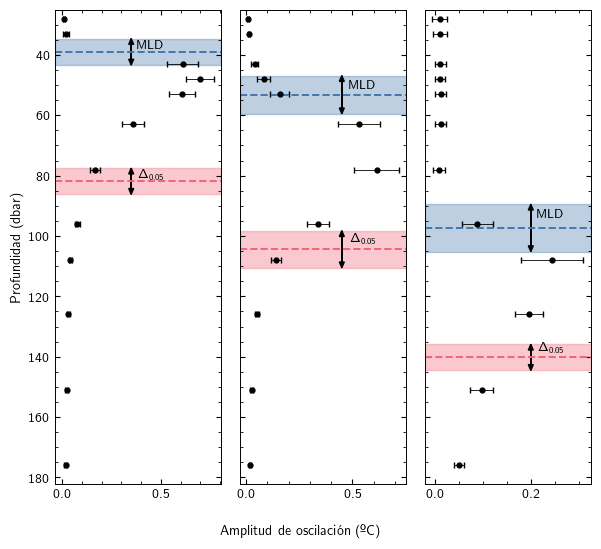

In [23]:
fig, axs = plt.subplots(1, 3, figsize=get_figsize(0.97, 0.9), sharey=True)
axs[0].set_ylim(182, 25)


plot_column_oscilation_axes(axs[0], nov_term, 'M2', nov_fit.D1, nov_delta05ci, pos1=[0.45, 36.8], 
                       pos2=[0.45, 79.785], x_arrow=0.35, save='colum_oscilation_M2_november.pdf')


plot_column_oscilation_axes(axs[1], dec_term, 'M2', dec_fit.D1, dec_delta05ci, pos1=[0.55, 50], 
                       pos2=[0.55, 101], x_arrow=0.45,
                       save='colum_oscilation_M2_dec.pdf')

plot_column_oscilation_axes(axs[2], jan_term, 'M2', jan_fit.D1, nov_delta05ci, pos1=[0.242, 93], 
                       pos2=[0.242, 137], x_arrow=0.20, ylim=[181, 73],
                       save='colum_oscilation_M2_jan.pdf')

axs[0].set_ylabel('Profundidad (dbar)')
fig.supxlabel('Amplitud de oscilación (ºC)', fontsize=10)
fig.tight_layout()
fig.savefig(figures_dir / 'three.pdf')
plt.show()

### Periodos 

In [32]:
period_1 = slice(None, datetime(2018, 11, 24), 360)
period_2 = slice(datetime(2018, 11, 30), datetime(2018, 12, 9), 360)
period_3 = slice(datetime(2019, 1, 5), datetime(2019, 1, 14), 360)

chain_period_1 = chain.sel(date=period_1)
chain_period_2 = chain.sel(date=period_2)
chain_period_3 = chain.sel(date=period_3)

fit_period_1 = fit_chain[period_1]
fit_period_2 = fit_chain[period_2]
fit_period_3 = fit_chain[period_3]



period_list = [chain_period_1, chain_period_2, chain_period_3]
fit_list = [fit_period_1, fit_period_2, fit_period_3]

In [371]:
jan_fit.D1

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,81.087080,214.759075,7.815364,1.045273,37.100553,7.652328
K1,23.934470,9.448694,4.127562,2.667837,2.573763,140.877514,55.323839
M4,6.210301,4.163415,13.437969,1.770917,0.946864,182.789965,30.543146
M3,8.280401,2.540387,8.962437,1.383322,0.905662,316.822371,37.506480
M6,4.140200,2.030744,9.410974,1.236804,0.790205,165.739202,36.577413


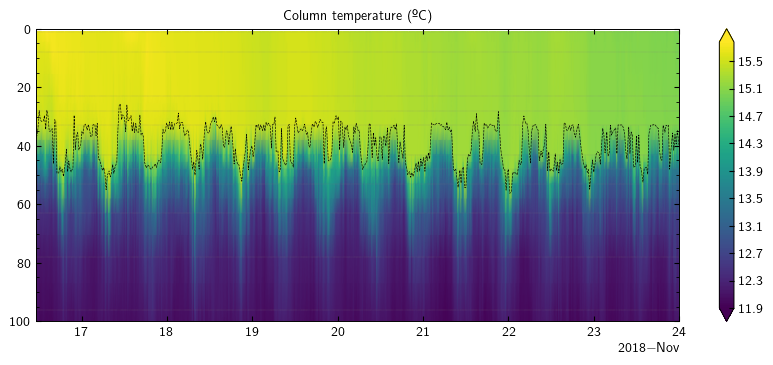

In [17]:
plot_column_temperature(chain, fit_chain, period=[None, date_1], ylims=[100, 0])

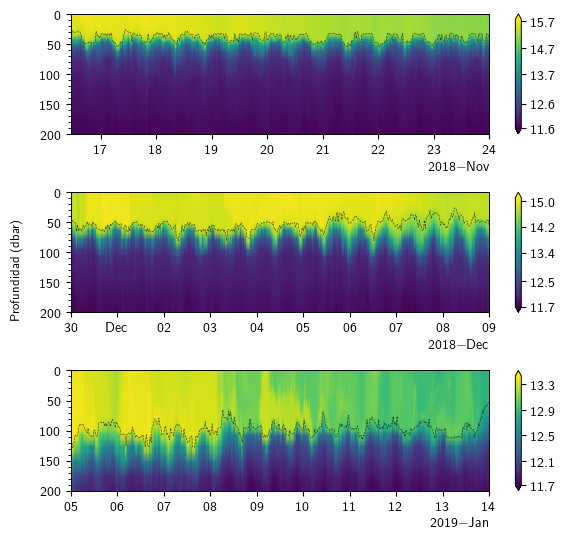

In [36]:
fig, axs = plt.subplots(3, figsize=get_figsize(0.97, 0.9), sharex=False)
cmap = plt.colormaps['viridis']
cbars = []
for (ax, period, fit) in zip(axs.reshape(3), period_list, fit_list):
    
    locator = mdates.AutoDateLocator(minticks=4, maxticks=None)
    formatter = mdates.ConciseDateFormatter(locator)
    minor_locator = mdates.AutoDateLocator(minticks=6)
    
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_minor_locator(minor_locator)
    
    levels = MaxNLocator(nbins=256).tick_values(period.temp.min(), period.temp.max())
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    ax.set_ylim(200, 0)
    x, y = np.meshgrid(period.date, chain.depth)
    
    im = ax.pcolormesh(x.T, y.T, period.temp, cmap=cmap, norm=norm, shading='gouraud')
    cbar = fig.colorbar(im, ax=ax, extend='both')
    cbars.append(cbar)
    
    ax.plot(period.date, fit.D1, c='black', lw=0.45, ls='--', alpha=0.7)
    
    cbar.ax.tick_params(which='minor', axis='y', right=False)
    cbar.ax.tick_params(which='major', axis='y', direction='out')
    ax.tick_params(axis='x', which='both', direction='out', top=None)
    ax.tick_params(axis='x', which='minor', bottom=None)
    ax.tick_params(axis='y', which='both', direction='out', right=None)

cbars[0].ax.set_yticks(np.round(np.linspace(11.64, 15.67, 5),1), minor=False)
cbars[1].ax.set_yticks(np.round(np.linspace(11.70, 15.0, 5),1), minor=False)
cbars[2].ax.set_yticks(np.round(np.linspace(11.71, 13.3, 5),1), minor=False)   

fig.supylabel('Profundidad (dbar)', fontsize=9)
fig.tight_layout()
fig.savefig(figures_dir / 'periods_utide.pdf', dpi=300)
plt.show()

### Internal solitons D1 vs G005

In [70]:
def plot_D1_and_G005(figsize, D1, G005, period=[None, None], xlim=None, ylim=None, save=None):
    slice_ = slice(*period)
    D1_ = D1.loc[slice_]
    G005_ = G005.loc[slice_]
    date = D1[slice_].index

    fig, ax1 = plt.subplots(figsize=figsize)
    locator = mdates.AutoDateLocator(minticks=4, maxticks=None)
    formatter = mdates.ConciseDateFormatter(locator)
    minor_locator = mdates.AutoDateLocator(minticks=6)
    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(formatter)
    ax1.xaxis.set_minor_locator(minor_locator)
    ax1.plot(date, D1_)
    ax1.set_ylabel(r'MLD (db)', color=colors[0])  # we already handled the x-label with ax1
    #ylim = ax1.get_ylim()
    #ax1.set_ylim(ylim[1], ylim[0])
    ax1.tick_params(axis='y', colors=colors[0], which='both')


    ax2 = ax1.twinx()
    ax2.plot(date, G005_, color=colors[1])
    ax2.tick_params(axis='y', colors=colors[1], which='both')
    ax2.set_ylabel('$G_{0.05}$', color=colors[1])  # we already handled the x-label with ax1
    plt.gcf().set_dpi(130)
    plt.show()

In [68]:
D1_filt_64 = lowpass_filter(fit_chain.D1, chain.date, 1/5, 1/64)
G005_filt_64 = lowpass_filter(G05.x, chain.date, 1/5, 1/64)

In [56]:
#soliton_1
period_soliton1 = [datetime(2018, 11, 21, 10), datetime(2018, 11, 21, 12, 15)]

#soliton_2 
period_soliton2 = [datetime(2018, 11, 19, 22), datetime(2018, 11, 20, 1)] 

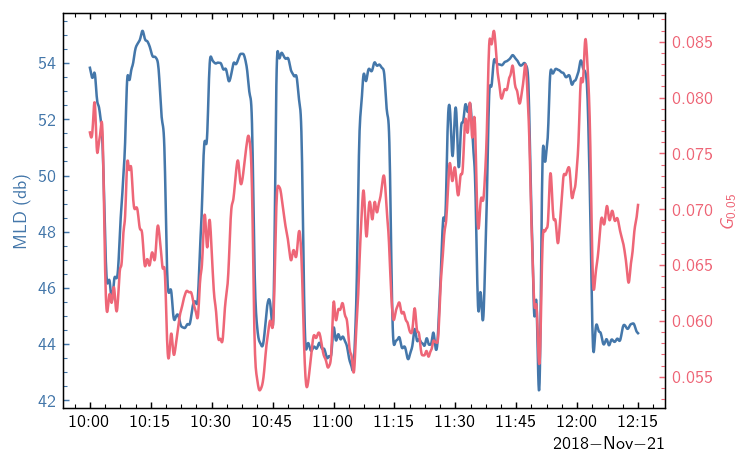

In [74]:
figsize=get_figsize(0.95, 0.66)
plot_D1_and_G005(figsize, D1_filt_64, G005_filt_64, period=period_soliton1)

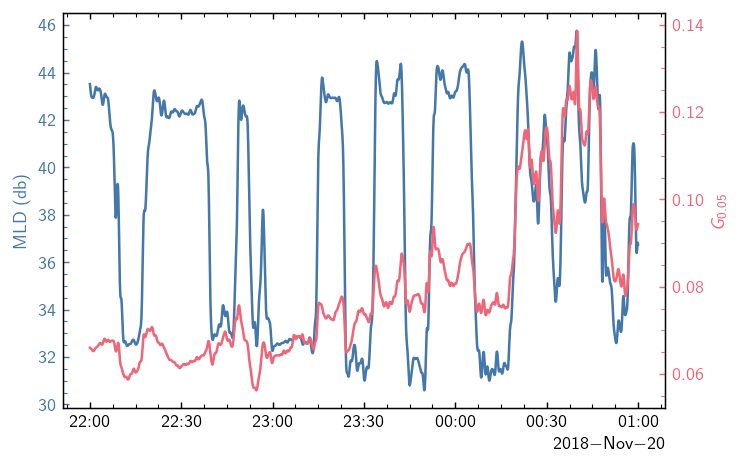

In [75]:
plot_D1_and_G005(figsize, D1_filt_64, G005_filt_64, period=period_soliton2)

### Internal tides D1 vs G005

In [140]:
hi = period_to_freq(1, 'h')
D1_filt_1800 = lowpass_filter(fit_chain.D1, chain.date, 1/5, hi)
G005_filt_1800 = lowpass_filter(G05.x, chain.date, 1/5, hi)

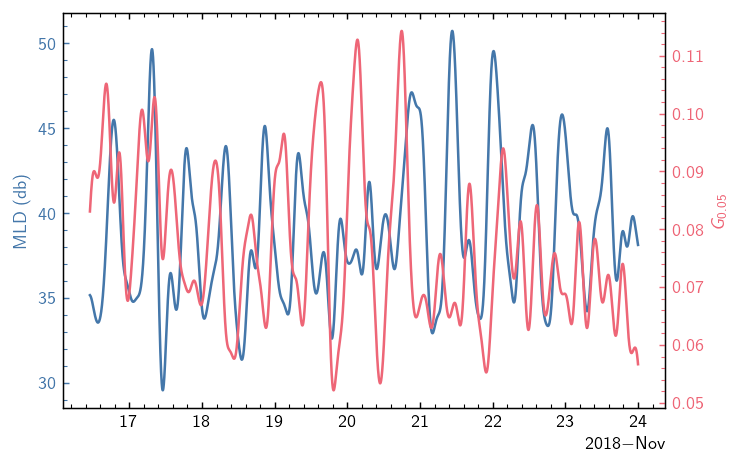

In [91]:
plot_D1_and_G005(figsize, D1_filt_1800, G005_filt_1800, period=[None, date_1])

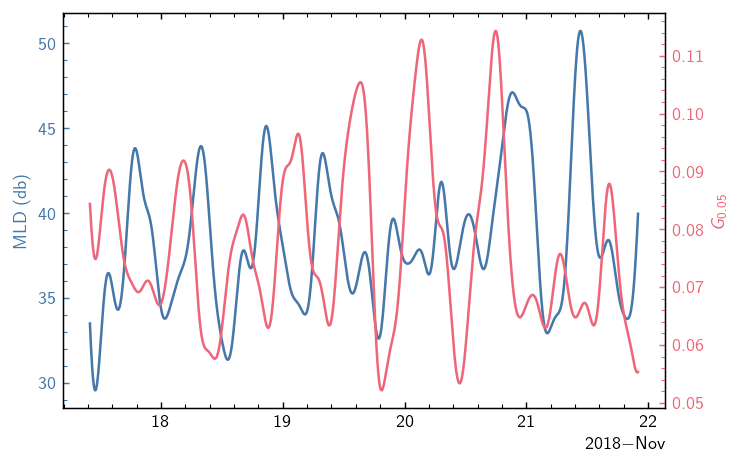

In [100]:
plot_D1_and_G005(figsize, D1_filt_1800, G005_filt_1800, period=[datetime(2018, 11, 17, 10), datetime(2018, 11, 21, 22)])

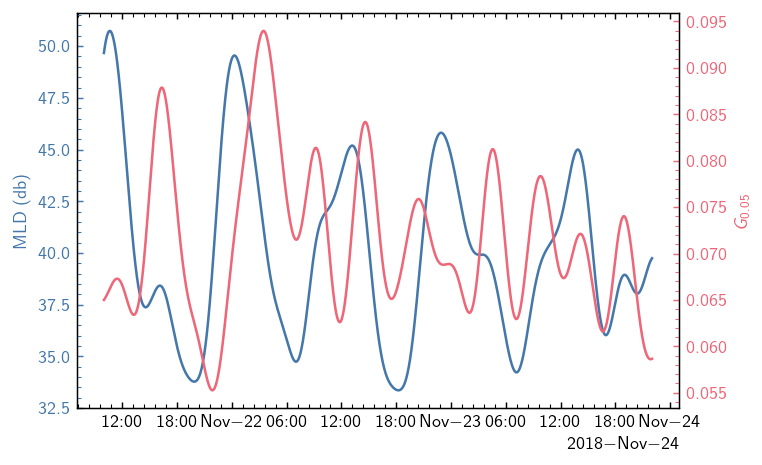

In [101]:
plot_D1_and_G005(figsize, D1_filt_1800, G005_filt_1800, period=[datetime(2018, 11, 21, 10), datetime(2018, 11, 23, 22)])

In [180]:
period_test = slice(datetime(2018, 11, 21, 10), datetime(2018, 11, 23, 22))
period_test2 = slice(datetime(2018, 11, 17, 10), datetime(2018, 11, 21, 22))

In [183]:
ccf_12 = ccf(D1_filt_1800[period_test2], G005_filt_1800[period_test2], adjusted=False)

In [184]:
np.argmin(ccf_12)*5/60/60

24.623611111111114

In [185]:
np.argmax(ccf_12)*5/60/60

17.425

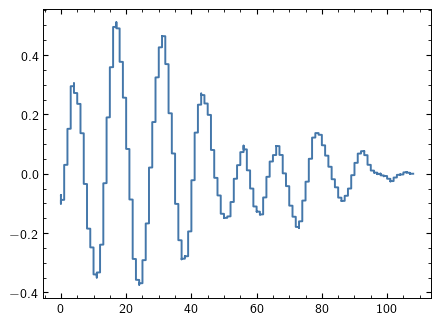

In [187]:
plt.plot((chain.date.loc[period_test2] - chain.date.loc[datetime(2018, 11, 17, 10)])/3.6e12, ccf_12)

In [188]:
24 - 17.45

6.550000000000001